# HW-4 DNN

## Importing Data and Preprocessing

In [1]:
import pandas as pd
import requests
from io import StringIO
import matplotlib.pyplot as plt

# Fetch the CSV data
url = 'https://raw.githubusercontent.com/PJalgotrader/Deep_Learning-USU/refs/heads/main/data/Logan_housing.csv'
response = requests.get(url)

# Read the CSV into a pandas DataFrame
csv_data = StringIO(response.text)
df = pd.read_csv(csv_data)

df.head()

,Sold Price,DOM,Garage Capacity,HOA Fee,Irregular Shape,Quadrant,School District,Sold Terms,Total Bedrooms,Total Bathrooms,Total Square Feet,Year Built,Zip,year_sold,month_sold,built_after_2000
0,176000,5,2,0,No,NW,Cache,FHA,3,1,1031,1974,84335,2018,9,0
1,225000,6,2,0,No,NW,Cache,Conventional,4,2,2091,1995,84335,2018,7,0
2,274900,14,2,0,No,NW,Cache,Conventional,3,1,2016,1980,84335,2018,11,0
3,175000,16,1,0,No,NW,Cache,USDA Rural Development,4,1,1920,1978,84335,2018,6,0
4,179000,29,0,0,No,NW,Cache,Cash,4,2,1329,1976,84335,2018,9,0


### Missing Values

In [2]:
# checking missing values
df.isnull().sum()

Sold Price           0
DOM                  0
Garage Capacity      0
HOA Fee              0
Irregular Shape      0
Quadrant             0
School District      0
Sold Terms           0
Total Bedrooms       0
Total Bathrooms      0
Total Square Feet    0
Year Built           0
Zip                  0
year_sold            0
month_sold           0
built_after_2000     0
dtype: int64

There are no missing values

### Data Types

In [3]:
# checking data types
df.nunique()

Sold Price           1217
DOM                   248
Garage Capacity        14
HOA Fee                96
Irregular Shape         2
Quadrant                4
School District         2
Sold Terms              6
Total Bedrooms          9
Total Bathrooms         7
Total Square Feet    2009
Year Built            136
Zip                    16
year_sold               3
month_sold             12
built_after_2000        2
dtype: int64

In [4]:
# converting columns to categorical
categorical_col = ['Garage Capacity', 'Irregular Shape', 'Quadrant', 'School District', 'Sold Terms', 'Zip', 'built_after_2000', 'month_sold']
for col in categorical_col:
    df[col] = df[col].astype('category')

# converting columns to float
float_col = ['Sold Price', 'DOM', 'HOA Fee', 'Total Bedrooms', 'Total Bathrooms', 'Total Square Feet', 'Year Built', 'year_sold']
for col in float_col:
    df[col] = df[col].astype('float')

### Creating dummy variables

In [5]:
# creating dummy variables for categorical columns
df = pd.get_dummies(df, drop_first=True)

# display the shape of the data
df.shape

(4110, 58)

In [6]:
df.head()

,Sold Price,DOM,HOA Fee,Total Bedrooms,Total Bathrooms,Total Square Feet,Year Built,year_sold,Garage Capacity_1,Garage Capacity_2,...,month_sold_4,month_sold_5,month_sold_6,month_sold_7,month_sold_8,month_sold_9,month_sold_10,month_sold_11,month_sold_12,built_after_2000_1
0,176000.0,5.0,0.0,3.0,1.0,1031.0,1974.0,2018.0,False,True,...,False,False,False,False,False,True,False,False,False,False
1,225000.0,6.0,0.0,4.0,2.0,2091.0,1995.0,2018.0,False,True,...,False,False,False,True,False,False,False,False,False,False
2,274900.0,14.0,0.0,3.0,1.0,2016.0,1980.0,2018.0,False,True,...,False,False,False,False,False,False,False,True,False,False
3,175000.0,16.0,0.0,4.0,1.0,1920.0,1978.0,2018.0,True,False,...,False,False,True,False,False,False,False,False,False,False
4,179000.0,29.0,0.0,4.0,2.0,1329.0,1976.0,2018.0,False,False,...,False,False,False,False,False,True,False,False,False,False


Based on the shape of the data the minimum number of nodes in the first layer should be 46. This is so we don't create a bottleneck.

### Train Test Split

In [7]:
# splitting the data into train and test
from sklearn.model_selection import train_test_split

X = df.drop('Sold Price', axis=1, inplace=False).values
y = df['Sold Price'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

In [8]:
X.shape

(4110, 57)

### Standard Scaler

In [9]:
# scaling the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Tensorflow

In [10]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers
from tensorflow import keras

### Creating model without dropout

In [11]:
# let's make a function to create the model. This is an important step, because 
# every time you want to fit (train) a new model, you don't want to retrain it on the existing one! 
def build_model():
    model = keras.Sequential(name="my_classification_model")
    model.add(layers.Input(shape=(X_train.shape[1],))) # this is the shape of each sample! 
    model.add(layers.Dense(units = 180, activation = 'relu', name="first_layer"))
    model.add(layers.Dense(units = 32, activation = 'relu', name="second_layer"))

    #output layer
    model.add(layers.Dense(units = 1, activation = 'linear', name="output_layer"))
    model.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=['mae'])
    return model

In [12]:
early_stopping   = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
model_checkpoint = ModelCheckpoint(monitor='val_loss', save_best_only=True, filepath="model_checkpoint.keras")
callback_list    = [early_stopping,model_checkpoint]

In [13]:
model = build_model()

### Creating Model with dropout

In [14]:
def build_model_with_dropout():
    model = keras.Sequential(name="my_classification_model_with_Dropout")
    model.add(layers.Input(shape=(X_train.shape[1],))) # this is the shape of each sample! 
    model.add(layers.Dense(units = 180, activation = 'relu', name="first_layer"))
    model.add(layers.Dropout(rate=0.5)) # 50% of nuerons will be randomly dropped out. 
    
    model.add(layers.Dense(units = 32, activation = 'relu', name="second_layer"))
    model.add(layers.Dropout(rate=0.5))
    
    #output layer
    model.add(layers.Dense(units = 1, activation = 'linear', name="output_layer"))
    model.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=['mae'])
    return model

In [15]:
model_with_dropout = build_model_with_dropout()
model_with_dropout.summary()

Model: "my_classification_model_with_Dropout"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ first_layer (Dense)             │ (None, 180)            │        10,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 180)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ second_layer (Dense)            │ (None, 32)             │         5,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,265 (63.54 KB)

 Trainable params: 16,265 (63.54 KB)

 Non-trainable params: 0 (0.00 B)

1. There are 10,400 params in the first layer, 5,792 paramms in the second layer, and 33 params in the third layer. The total params are then 16,265 which is a summation of the 3 layers params.
2. we should use linear activiation function
3. we should use the mse loss function

### Training models

In [16]:
# training model without drop out
model.fit(X_train,y_train, validation_data=(X_test, y_test), epochs=2000, batch_size=128, 
          callbacks=callback_list)

Epoch 1/2000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 90795704320.0000 - mae: 278807.6250 - val_loss: 94381768704.0000 - val_mae: 283952.1875
Epoch 2/2000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 94305550336.0000 - mae: 282413.6250 - val_loss: 94372225024.0000 - val_mae: 283938.0000
Epoch 3/2000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 92328968192.0000 - mae: 281233.3125 - val_loss: 94356897792.0000 - val_mae: 283916.0000
Epoch 4/2000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 95919988736.0000 - mae: 282526.0000 - val_loss: 94335246336.0000 - val_mae: 283885.3438
Epoch 5/2000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 91681480704.0000 - mae: 280523.0938 - val_loss: 94305075200.0000 - val_mae: 283843.4375
Epoch 6/2000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 96622854144.0000 - mae: 282368.5312 - val_loss: 94266531840.0000 - val_mae: 283790.4062
Epoch 7/2000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 90855284736.0000 - mae: 279536.5938 - val_loss: 9421

In [17]:
# training model with drop out
model_with_dropout.fit(X_train,y_train, validation_data=(X_test, y_test), epochs=2000, batch_size=128, 
          callbacks=callback_list)

Epoch 1/2000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 91232329728.0000 - mae: 280769.0938 - val_loss: 94384685056.0000 - val_mae: 283956.6875
Epoch 2/2000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 94449582080.0000 - mae: 282447.5938 - val_loss: 94379941888.0000 - val_mae: 283949.3125
Epoch 3/2000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 92635914240.0000 - mae: 281831.3125 - val_loss: 94372511744.0000 - val_mae: 283938.1250
Epoch 4/2000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step - loss: 93475512320.0000 - mae: 281615.3750 - val_loss: 94361575424.0000 - val_mae: 283922.0312
Epoch 5/2000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step - loss: 92366020608.0000 - mae: 280297.7500 - val_loss: 94346141696.0000 - val_mae: 283899.8438
Epoch 6/2000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 89807298560.0000 - mae: 277739.4062 - val_loss: 94325506048.0000 - val_mae: 283870.5938
Epoch 7/2000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 94268284928.0000 - mae: 282732.3438 - val_loss: 

### Plotting loss and val_loss

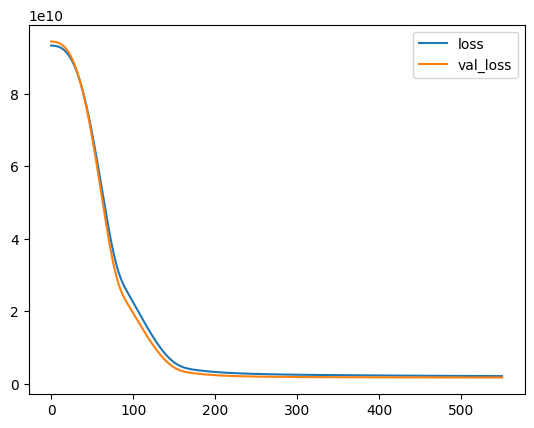

In [18]:
loss_df = pd.DataFrame(model.history.history)
loss_df[['loss', 'val_loss']].plot(legend=True)
plt.show()

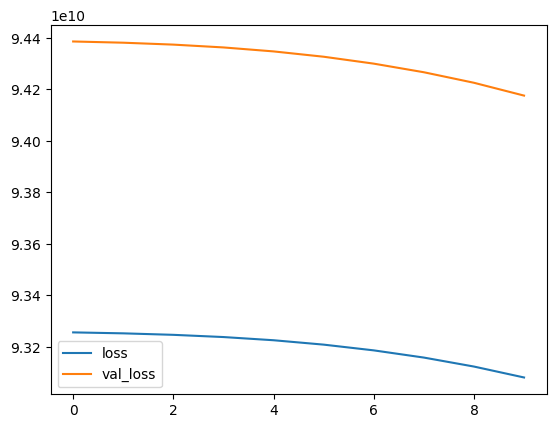

In [19]:
loss_df_with_dropout = pd.DataFrame(model_with_dropout.history.history)
loss_df_with_dropout[['loss', 'val_loss']].plot(legend=True)
plt.show()

The val_loss is lower in the model without drop out. This must be due to the model overfitting

### Evaluating the model without dropout

In [20]:
model.evaluate(X_test, y_test)

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step - loss: 1483012096.0000 - mae: 25622.8223


[1808465792.0, 27268.875]

### Making predictions

In [21]:
y_test_probs = model.predict(X_test)

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step


### Reporting Metrics

In [22]:
from sklearn.metrics import mean_absolute_percentage_error, explained_variance_score, r2_score

In [23]:
# Calculate the metrics
mape = mean_absolute_percentage_error(y_test, y_test_probs)
explained_variance = explained_variance_score(y_test, y_test_probs)
r2 = r2_score(y_test, y_test_probs)

# Print the metrics
print(f"Mean Absolute Percentage Error (MAPE): {mape}")
print(f"Explained Variance Score: {explained_variance}")
print(f"R² Score: {r2}")

Mean Absolute Percentage Error (MAPE): 0.1243280268722158
Explained Variance Score: 0.8687032460100728
R² Score: 0.8685090877250514


Based on these metrics the model is performing fairly well

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step


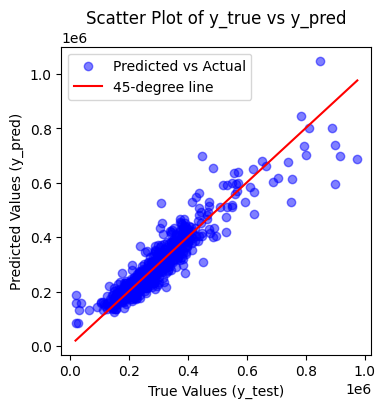

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming y_test and y_pred are the actual and predicted values
y_pred = model.predict(X_test)

# Scatter plot of y_true vs y_pred
plt.figure(figsize=(4, 4))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue', label='Predicted vs Actual')

# Add a 45-degree line (perfect prediction line)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', label='45-degree line')

# Add labels and title
plt.title('Scatter Plot of y_true vs y_pred')
plt.xlabel('True Values (y_test)')
plt.ylabel('Predicted Values (y_pred)')
plt.legend()

# Show plot
plt.show()

I would be satisfied with the plot. The higher values appear to be where the model is struggling to perform well. This may be due to a lack of data in those points. Certain homes selling at a higher price point are not majority of the data.

## Pycaret Comparison

In [25]:
from pycaret.regression import *

In [26]:
exp = RegressionExperiment()
exp.setup(data=df, target='Sold Price', session_id=100)

,Description,Value
0,Session id,100
1,Target,Sold Price
2,Target type,Regression
3,Original data shape,"(4110, 58)"
4,Transformed data shape,"(4110, 58)"
5,Transformed train set shape,"(2877, 58)"
6,Transformed test set shape,"(1233, 58)"
7,Numeric features,7
8,Preprocess,True
9,Imputation type,simple


In [27]:
best = exp.compare_models(sort='MAE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,26961.7337,3079046589.9342,53319.1334,0.7789,0.1482,0.0965,0.1690
rf,Random Forest Regressor,27165.6032,3098848983.6235,53099.7857,0.7799,0.1512,0.0983,0.1880
lightgbm,Light Gradient Boosting Machine,27366.7367,2947450357.1315,52258.5238,0.7880,0.1529,0.0994,0.2950
gbr,Gradient Boosting Regressor,28458.0662,3201652244.7358,54372.5702,0.7686,0.1548,0.1045,0.0650
lr,Linear Regression,30916.5637,3260332672.0000,55305.0629,0.7649,0.1856,0.1255,0.3220
lasso,Lasso Regression,30930.5186,3263377766.4000,55340.2219,0.7647,0.1856,0.1255,0.0150
llar,Lasso Least Angle Regression,30930.5621,3263364147.2000,55340.1312,0.7647,0.1856,0.1255,0.0060
ridge,Ridge Regression,30997.7611,3246373440.0000,55061.5305,0.7671,0.1862,0.1263,0.0040
br,Bayesian Ridge,31106.8158,3269455680.0000,55257.9582,0.7652,0.1869,0.1269,0.0070
en,Elastic Net,33761.4588,3743473868.8000,59363.4109,0.7283,0.2018,0.1397,0.0110


In [28]:
tuned = exp.tune_model(best, optimize='MAE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,28139.3428,2565715796.3619,50652.8952,0.7306,0.1460,0.0915
1,25811.5854,1616884774.4581,40210.5058,0.8501,0.1276,0.0889
2,22916.1367,1633493490.0032,40416.5002,0.8459,0.1649,0.1046
3,28014.5736,4340319033.0664,65881.0977,0.6916,0.1679,0.0965
4,25308.4632,2050745043.0607,45285.1526,0.8512,0.1843,0.1161
5,34546.2974,5464802855.9315,73924.3049,0.7066,0.1840,0.1204
6,25837.9243,1902084480.1047,43612.8935,0.8291,0.1510,0.0964
7,25382.4042,2443471786.9023,49431.4858,0.8370,0.1183,0.0856
8,28998.1208,8353546387.1042,91397.7373,0.5696,0.1334,0.0821


Fitting 10 folds for each of 10 candidates, totalling 100 fits


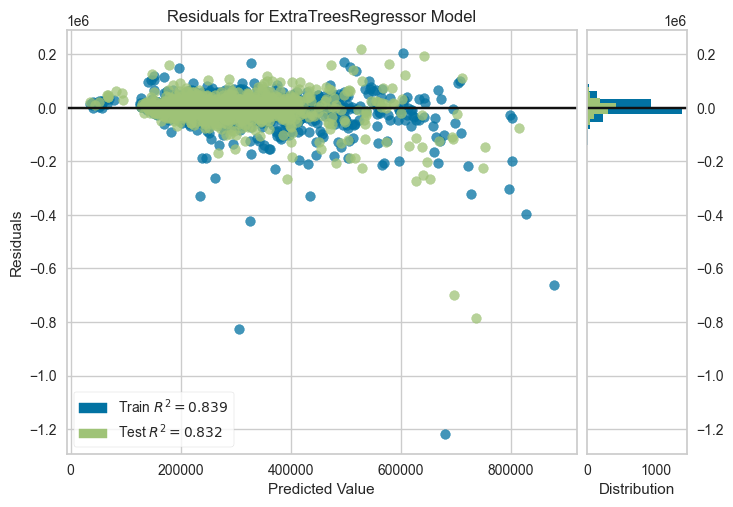

In [29]:
exp.plot_model(tuned, plot='residuals')